<a href="https://colab.research.google.com/github/yeonghun00/stock-notes/blob/main/tools/low_traded_incrased_stocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

기간 입력

거래대금 하위 10%~50%

등락률 상위 50%~10%

클라스로 만들어서 백테스팅 가능하게 ㄱ

In [1]:
!pip install exchange_calendars

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 189 kB 20.2 MB/s 


In [2]:
!pip install finance-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


250일 등락률, 거래대금 90-99: 범인매매

60일 등락률 50-100, 거래대금 10-50 : 조용히 오르는 애들 (내꺼)



In [3]:
conditions = {
    'increased_low' : 0.5,
    'increased_high' : 1,
    'traded_low' : 0.1,
    'traded_high' : 0.5
 }

In [4]:
import pandas as pd
import requests
import datetime
import exchange_calendars as ecals # 개장일만

In [5]:
XKRX = ecals.get_calendar("XKRX") # 한국 코드

In [6]:
from io import StringIO
import FinanceDataReader as fdr
import numpy as np

class Filter:
  def __init__(self, date, period, dic):
    self.date = date.strftime('%Y%m%d')
    self.previous = (date - datetime.timedelta(days=period)).strftime('%Y%m%d')
    self.next = (date + datetime.timedelta(days=period)).strftime('%Y%m%d')


    if XKRX.is_session(self.date) == False:
      self.date = XKRX.previous_open(self.date).strftime('%Y%m%d')
    if XKRX.is_session(self.previous) == False:
      self.previous = XKRX.next_open(self.previous).strftime('%Y%m%d')
    if XKRX.is_session(self.next) == False:
      self.next = XKRX.previous_open(self.next).strftime('%Y%m%d')

    self.price_dic = {}
    self.dic = dic
    self.df = self.get_df()
    self.result_df = self.get_filtered()
    self.get_prices()
    self.add_risk()
    self.add_performance()
    self.result_df = self.get_result()

  def get_stocks(self, market='STK'):
    data = {
      'mktId': market,
      'strtDd': self.previous,
      'endDd': self.date,
      'money': '1',
      'adjStkPrc': '2',
      'adjStkPrc_check': 'Y',
      'share': '1',
      'csvxls_isNo': 'false',
      'name': 'fileDown',
      'url': 'dbms/MDC/STAT/standard/MDCSTAT01602'
    }
    gen_url = 'http://data.krx.co.kr/comm/fileDn/GenerateOTP/generate.cmd'
    gen_key = requests.post(gen_url, data=data)

    down_url = 'http://data.krx.co.kr/comm/fileDn/download_csv/download.cmd'
    r = requests.post(down_url, data={'code':gen_key.text})
    r.encoding = 'EUC-KR'

    return pd.read_csv(StringIO(r.text))

  def get_df(self):
    df = pd.concat([self.get_stocks(), self.get_stocks('KSQ')]).reset_index(drop=True)
    return df

  def get_filtered(self):
    traded_df = self.df[(self.df['거래대금'] < self.df['거래대금'].quantile(self.dic['traded_high'])) & (self.df['거래대금'] > self.df['거래대금'].quantile(self.dic['traded_low']))]
    increased_df = self.df[(self.df['등락률'] > self.df['등락률'].quantile(self.dic['increased_low'])) & (self.df['등락률'] < self.df['등락률'].quantile(self.dic['increased_high']))]
    selected = pd.Series(np.intersect1d(traded_df['종목명'].values, increased_df['종목명'].values))
    result_df = self.df[self.df['종목명'].isin(selected)].sort_values('등락률', ascending=False).head(20)
    return result_df

  def get_prices(self):
    for i in self.result_df['종목코드']:
      self.price_dic[i] = fdr.DataReader(str(i), self.previous, self.next)

  def get_sharpe(self, df):
    change = df['Change']+1
    return change.mean()/change.std()

  def get_sortino(self, df):
    change = df['Change']+1
    return change.mean()/(change[change<1]).std()

  def add_risk(self):
    self.result_df['샤프'] = [self.get_sharpe(self.price_dic[x][:self.date]) for x in self.price_dic]
    self.result_df['소티노'] = [self.get_sortino(self.price_dic[x][:self.date]) for x in self.price_dic]
  
  def add_performance(self):
    self.result_df['미래'] = [self.price_dic[x]['Close'][self.next]/self.price_dic[x]['Close'][self.date:].iloc[1] for x in self.price_dic]
    self.result_df['미래샤프'] = [self.get_sharpe(self.price_dic[x][self.date:].iloc[1:]) for x in self.price_dic]
    self.result_df['미래소티노'] = [self.get_sortino(self.price_dic[x][self.date:].iloc[1:]) for x in self.price_dic]

  def get_result(self, risk='샤프', rank=10):
    return self.result_df.sort_values(risk, ascending=False).head(rank)

In [7]:
date = datetime.datetime.strptime('20220101', '%Y%m%d')

In [8]:
f = Filter(date, 60, conditions)

In [9]:
f.result_df

,종목코드,종목명,시작일 기준가,종료일 종가,대비,등락률,거래량,거래대금,샤프,소티노,미래,미래샤프,미래소티노
1597,083930,아바코,10250,12700,2450,23.90,3208981,37671873880,47.725288,81.028863,0.869048,34.947195,56.489236
710,007815,코리아써우,6920,8760,1840,26.59,1027140,8189459780,44.734868,85.451320,1.048523,31.647962,63.832878
1896,095270,웨이브일렉트로,4390,5440,1050,23.92,2865529,14366251205,38.342664,86.466803,1.091408,46.714342,81.083856
691,051630,진양화학,4400,5500,1100,25.00,4618568,22370101775,35.585429,51.717429,1.203811,29.121488,46.862565
2139,221980,케이디켐,16000,20300,4300,26.88,1351720,26760583450,35.539187,72.483520,0.779951,48.354821,78.435059
1498,208370,셀바스헬스케어,2360,3000,640,27.12,11594618,32457108075,31.116062,51.631786,1.086811,17.838320,36.590600
1762,070300,엑스큐어,3250,4240,990,30.46,3292768,13006388715,29.280349,43.151190,0.917453,34.884640,42.803016
1471,081580,성우전자,2795,3890,1095,39.18,8621502,28366821465,28.468780,52.603016,0.917722,27.991965,49.308313
2150,272110,케이엔제이,13500,17150,3650,27.04,3608359,56401817400,28.394506,66.791752,0.829851,37.173279,58.532408
2394,070590,한솔인티큐브,2680,3340,660,24.63,5863148,16959362650,27.599854,50.175863,0.846043,36.305217,54.244633


In [10]:
f.result_df['미래'].mean()

0.9590620651757114

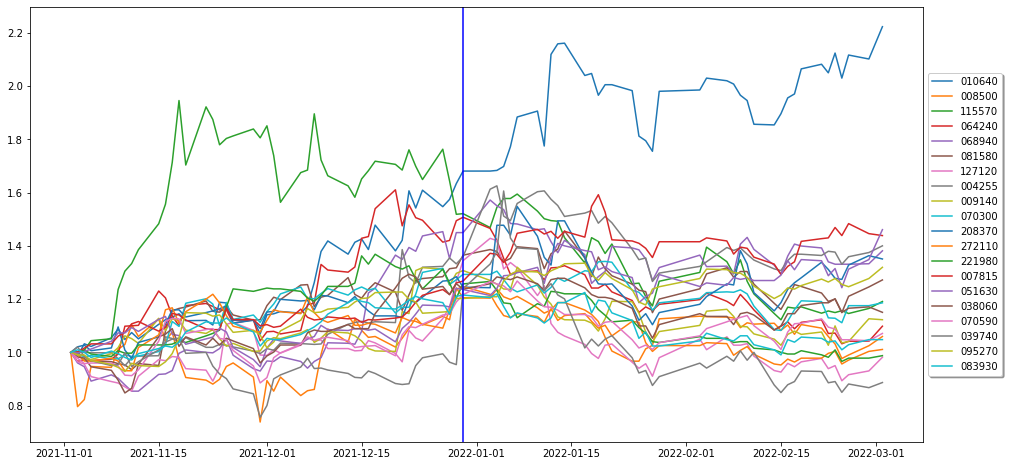

In [11]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16, 8))
ax = plt.subplot(111)

for i in f.price_dic:
  ax.plot(f.price_dic[i]['Close']/f.price_dic[i]['Close'][0], label=i)
ax.axvline(x = datetime.datetime.strptime(f.date, '%Y%m%d'), color = 'b')
ax.legend(loc='center left',  bbox_to_anchor=(1, 0.5), fancybox=True, shadow=True)

plt.show()